In [68]:
import pickle as pkl
from tqdm import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from collections import defaultdict
import math
import torch
import matplotlib.pyplot as plt
from collections import Counter

## Funções Auxiliares

In [69]:
def open_file(path):
    with open(path, "rb") as f:
        obj = pkl.load(f)
    f.close()
    return obj

In [70]:
def plot_scatter(collection):
    plt.scatter(range(len(collection)), collection, color='blue', label='Valores')
    plt.xlabel('Índice')
    plt.ylabel('Valores')
    plt.title('Gráfico de Dispersão')
    plt.legend()
    plt.show()

# Analise

In [71]:
user_cat = open_file("datasets/out/df_candidate.pkl")
user_ids = user_cat['user'].values
user_ids

array([     3,      4,      5, ..., 577925, 577933, 577935])

In [72]:
nn_predict = open_file("FilterFeatures/user_candidate_predict.pkl")

In [73]:
user_predict_itens = {user:cand[:nn_predict[user]] for user, cand in zip(user_cat['user'], user_cat['item_candidate'])}

## Importação de Features 

In [74]:
user_cat_val = open_file("FilterFeatures/user_cat_val.pkl")
item_cat_val = open_file("FilterFeatures/itens_cat_val.pkl")
user_cat_train = open_file("FilterFeatures/user_cat.pkl")
index2item = open_file("datasets/out/index2item.pkl")
index2user = open_file("datasets/out/index2user.pkl")
item_cat = open_file("FilterFeatures/itens_cat.pkl")

In [75]:
item2index = open_file("datasets/out/item2index.pkl")
user2index = open_file("datasets/out/user2index.pkl")

In [76]:
item_data = open_file("datasets/out/finetuning_2.pkl")
item_data.head()

,page,Unnamed: 0,url,issued,modified,title,body,caption,categorie,saida,label_ft,finetune
0,13db0ab1-eea2-4603-84c4-f40a876c7400,0,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...,am,apo audiencia custodia justica amazonas decret...,politica,"[0.9932261109352112, 0.9012693762779236, -0.96..."
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,1,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...,pa,vista aerea santar adrio denner ad producoe pa...,economia,"[-0.689832329750061, 0.21615354716777802, 0.80..."
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,2,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...,mundo,video mostrar assassino shinzo abe atirar cost...,mundo,"[-0.9931131601333618, -0.6926692724227905, 0.2..."
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,3,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...,politica,relator stf fachin vota marco temporal demarca...,politica,"[0.9959969520568848, 0.9293882846832275, -0.97..."
4,9dff71eb-b681-40c7-ac8d-68017ac36675,4,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic...",politica,apo pedido vista analise processo ministro ale...,politica,"[0.995829164981842, 0.9453511238098145, -0.949..."


In [77]:
user_iter = open_file("datasets/out/user_iter.pkl")
user_iter

,userId,history,timestampHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory
0,0,"[193275, 158881, 203270]","1657146417045, 1657146605778, 1657146698738","20380, 21184, 35438","50.3, 18.18, 16.46","2, 1, 1"
1,1,"[236644, 186368, 154787, 159227, 103615, 23330...","1656684240278, 1656761266729, 1656761528085, 1...","6049, 210489, 8672, 10000, 30000, 123007, 9965...","25.35, 45.66, 35.3, 28.05, 36.53, 47.57, 55.33...","1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1..."
2,2,"[217268, 105647, 37758, 60121, 96848, 4702, 11...","1656678946256, 1656701076495, 1656701882565, 1...","311274, 140000, 32515, 157018, 118689, 159243,...","67.58, 47.22, 41.52, 63.09, 51.38, 65.11, 71.9...","1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1..."
3,3,"[116062, 217268, 63616, 45463, 158309, 234064,...","1658333312180, 1658404553818, 1658408449062, 1...","182696, 91925, 30000, 273655, 126409, 42980, 1...","58.26, 72.66, 22.57, 59.89, 40.36, 36.35, 14.7...","1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1..."
4,4,"[12658, 88597, 148651, 165528]","1658766608801, 1658766608801, 1660084035094, 1...","801396, 801396, 10000, 10000","78.74, 78.74, 16.71, 9.34","7, 7, 1, 1"
...,...,...,...,...,...,...
77937,577937,"[223321, 8675]","1657326235808, 1660067897448","47320, 19387","46.63, 25.6","2, 1"
77938,577938,"[117768, 116040]","1659884923835, 1660163481828","40358, 10000","26.22, 50.04","2, 1"
77939,577939,"[206844, 108997]","1659482565430, 1659484173830","430000, 10000","28.1, 9.83","2, 1"
77940,577940,"[158882, 142191]","1659762125465, 1659764560346","169658, 183309","40.74, 53.26","2, 1"


In [78]:
user_historical_itens = open_file("DataPreProcessing/data_pro/train/UserItemHistorical.pkl")

## Popularidade de Itens no Treino

In [79]:
itens_2_count = user_historical_itens.values()
itens_counting = {}

for itens in itens_2_count:
    for item in itens:
        if item not in itens_counting.keys():
            itens_counting[item] = 1
        else:
            itens_counting[item] += 1

In [80]:
topk = dict(sorted(itens_counting.items(), key=lambda item: item[1], reverse=True))
topk = list(topk.keys())

## Popularidade de Itens na Validação

In [81]:
users_itens_counting = []

for itens in user_iter['history']:
    itens_famous = [itens_counting[x] for x in itens]
    users_itens_counting.append(itens_famous)

user_iter['famous'] = users_itens_counting

In [82]:
user_train_itens = {user:train for user, train in zip(user_iter['userId'], user_iter['history'])}

## Feedback Implícito: O quanto meu item é famoso e o quanto é importante para o usuário

In [83]:
# Posso multiplicar o scrollPercentageHistory vezes a pageVisitsCountHistory e atribuir isso como um feedback para a categoria
# Selecionar as categorias que meu usuário mais deu feedbacks
# Pegar os itens mais recentes da base em relação a essas categorias

In [84]:
user_iter['timeOnPageHistory'] = user_iter['timeOnPageHistory'].apply(lambda x: np.array([float(y.strip()) for y in x.split(",")]))

In [85]:
user_iter['scrollPercentageHistory'] = user_iter['scrollPercentageHistory'].apply(lambda x: np.array([float(y.strip()) for y in x.split(",")]))
user_iter['pageVisitsCountHistory'] = user_iter['pageVisitsCountHistory'].apply(lambda x: np.array([float(y.strip()) for y in x.split(",")]))

In [86]:
user_iter

,userId,history,timestampHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,famous
0,0,"[193275, 158881, 203270]","1657146417045, 1657146605778, 1657146698738","[20380.0, 21184.0, 35438.0]","[50.3, 18.18, 16.46]","[2.0, 1.0, 1.0]","[334, 134, 242]"
1,1,"[236644, 186368, 154787, 159227, 103615, 23330...","1656684240278, 1656761266729, 1656761528085, 1...","[6049.0, 210489.0, 8672.0, 10000.0, 30000.0, 1...","[25.35, 45.66, 35.3, 28.05, 36.53, 47.57, 55.3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[25, 2976, 287, 13, 32, 9, 70, 31, 177, 70, 56..."
2,2,"[217268, 105647, 37758, 60121, 96848, 4702, 11...","1656678946256, 1656701076495, 1656701882565, 1...","[311274.0, 140000.0, 32515.0, 157018.0, 118689...","[67.58, 47.22, 41.52, 63.09, 51.38, 65.11, 71....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","[2692, 13715, 1931, 19519, 951, 76, 487, 1125,..."
3,3,"[116062, 217268, 63616, 45463, 158309, 234064,...","1658333312180, 1658404553818, 1658408449062, 1...","[182696.0, 91925.0, 30000.0, 273655.0, 126409....","[58.26, 72.66, 22.57, 59.89, 40.36, 36.35, 14....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[9744, 2692, 1125, 963, 561, 4370, 120, 2927, ..."
4,4,"[12658, 88597, 148651, 165528]","1658766608801, 1658766608801, 1660084035094, 1...","[801396.0, 801396.0, 10000.0, 10000.0]","[78.74, 78.74, 16.71, 9.34]","[7.0, 7.0, 1.0, 1.0]","[76, 1068, 3666, 3666]"
...,...,...,...,...,...,...,...
77937,577937,"[223321, 8675]","1657326235808, 1660067897448","[47320.0, 19387.0]","[46.63, 25.6]","[2.0, 1.0]","[131, 1635]"
77938,577938,"[117768, 116040]","1659884923835, 1660163481828","[40358.0, 10000.0]","[26.22, 50.04]","[2.0, 1.0]","[372, 15885]"
77939,577939,"[206844, 108997]","1659482565430, 1659484173830","[430000.0, 10000.0]","[28.1, 9.83]","[2.0, 1.0]","[80, 216]"
77940,577940,"[158882, 142191]","1659762125465, 1659764560346","[169658.0, 183309.0]","[40.74, 53.26]","[2.0, 1.0]","[2683, 115]"


In [87]:
feedback = []

for (time, scroll, visit) in zip(user_iter['timeOnPageHistory'], user_iter['scrollPercentageHistory'], user_iter['pageVisitsCountHistory']):
    feedback.append(time * scroll * visit)

feedback[0]

array([2050228.  ,  385125.12,  583309.48])

In [88]:
# user_iter['feedback'] = feedback
user_iter.head()

,userId,history,timestampHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,famous
0,0,"[193275, 158881, 203270]","1657146417045, 1657146605778, 1657146698738","[20380.0, 21184.0, 35438.0]","[50.3, 18.18, 16.46]","[2.0, 1.0, 1.0]","[334, 134, 242]"
1,1,"[236644, 186368, 154787, 159227, 103615, 23330...","1656684240278, 1656761266729, 1656761528085, 1...","[6049.0, 210489.0, 8672.0, 10000.0, 30000.0, 1...","[25.35, 45.66, 35.3, 28.05, 36.53, 47.57, 55.3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[25, 2976, 287, 13, 32, 9, 70, 31, 177, 70, 56..."
2,2,"[217268, 105647, 37758, 60121, 96848, 4702, 11...","1656678946256, 1656701076495, 1656701882565, 1...","[311274.0, 140000.0, 32515.0, 157018.0, 118689...","[67.58, 47.22, 41.52, 63.09, 51.38, 65.11, 71....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","[2692, 13715, 1931, 19519, 951, 76, 487, 1125,..."
3,3,"[116062, 217268, 63616, 45463, 158309, 234064,...","1658333312180, 1658404553818, 1658408449062, 1...","[182696.0, 91925.0, 30000.0, 273655.0, 126409....","[58.26, 72.66, 22.57, 59.89, 40.36, 36.35, 14....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[9744, 2692, 1125, 963, 561, 4370, 120, 2927, ..."
4,4,"[12658, 88597, 148651, 165528]","1658766608801, 1658766608801, 1660084035094, 1...","[801396.0, 801396.0, 10000.0, 10000.0]","[78.74, 78.74, 16.71, 9.34]","[7.0, 7.0, 1.0, 1.0]","[76, 1068, 3666, 3666]"


## Categorias que o usuário deu maior feedback implícito

In [89]:
user_cat_feedback = {}

for (user, itens, feedback) in tqdm(zip(user_iter["userId"], user_iter['history'], user_iter['famous'])):
    if user in user_ids:
        cats = [item_cat[index2item[x]] for x in itens]
        catsPfeedback = zip(cats, feedback)
        catsPfeedback = sorted(catsPfeedback, key=lambda x: x[1], reverse=True)
        catsPfeedback = [x[0] for x in catsPfeedback]
        user_cat_feedback[user] = catsPfeedback

0it [00:00, ?it/s]

577942it [00:15, 37815.86it/s]


# Testes

## Itens mais recentes ∩ Categorias consumidas pelo usuário no treino ∩ Filtragem no Set de Candidatos

#### OBS: Todos os testes foram feitos testando ordenação: + Recentes, - Recentes, Em Relação a ultima interação do usuário na base

In [90]:
item_timestamp = open_file("FilterFeatures/item_timestamp.pkl")

In [91]:
cat_itens = {}

for item, cat in item_cat.items():
    if "esid:conteudo_editorial" not in item:
        if cat not in cat_itens:
            cat_itens[cat] = []
        
        cat_itens[cat].append(item)

In [92]:
def get_item_timestamp(item):
    return item_timestamp.get(item, 0)

In [93]:
cat_itens_ordReverse = {}

for cat, itens in cat_itens.items():
    itens = sorted(itens, key=get_item_timestamp, reverse=True)
    cat_itens_ordReverse[cat] = itens

In [94]:
## Teste de Sanidade
# from collections import Counter

# cat_count = Counter(user_cat_feedback[3])
# cat_count.most_common(1)[0][0]

## Teste: Conjunto de Itens representantes das categorias mais consumidas pelo user no treino proporcionalmente

In [95]:
user_cat_commun = {}

for user, cats in user_cat_val.items():
    counting = Counter(cats)
    most_com = counting.most_common(1)[0][0]
    user_cat_commun[user] = most_com

## Teste: Fator nostalgia - Qual métrica representa melhor o fator nostalgia adicionado na recomendação: Time on Page, Scroll Percentag, Visits Count?

In [96]:
user_itens_feedback = {}

for (user, itens, feedback) in tqdm(zip(user_iter["userId"], user_iter['history'], user_iter['pageVisitsCountHistory'])):
    if user in user_ids:
        itens_feed = list(zip(itens, feedback))
        itens_feed = sorted(itens_feed, key=lambda x: x[1], reverse=True)
        itens_feed = [x[0] for x in itens_feed]
        user_itens_feedback[user] = itens_feed

577942it [00:14, 39335.90it/s]


In [97]:
recommendation = {}

for user, cats in tqdm(user_cat_feedback.items()):
    val_itens = user_predict_itens[user]
    itens_train = user_itens_feedback[user]
    itens = val_itens + itens_train[:2]
    recommendation[user] = itens[:15]

100%|██████████| 112184/112184 [00:00<00:00, 1032463.32it/s]


## Teste: Top itens mais recentes da base, desconsiderando personalização por categorias consumidas do usuário

In [98]:
toprecents = dict(sorted(item_timestamp.items(), key=lambda item: item[1], reverse=True))
toprecents = toprecents.keys()
toprecents = [item2index[x] for x in toprecents]

In [99]:
user_cat = open_file("FilterFeatures/user_cat.pkl")
item_cat = open_file("FilterFeatures/itens_cat.pkl")

In [100]:
for user, itens in tqdm(recommendation.items()):
    if len(itens) < 15:
        counting = 0
        plus_itens = []
        for x in toprecents:
            
            if item_cat[index2item[x]] in user_cat[user]:
                plus_itens.append(x)
                counting += 1

            if counting == 15:
                break

        recommendation[user] += plus_itens
        recommendation[user] = recommendation[user][:15]

100%|██████████| 112184/112184 [00:03<00:00, 28113.93it/s]


In [101]:
recommendation

{3: [43755,
  211444,
  12880,
  219677,
  116062,
  155137,
  100894,
  178577,
  12880,
  239791,
  211444,
  28793,
  71033,
  43755,
  236407],
 4: [148651,
  165528,
  12658,
  88597,
  186345,
  93970,
  178691,
  70126,
  136227,
  204611,
  46616,
  157191,
  42826,
  69834,
  236644],
 5: [167094,
  167094,
  244576,
  155137,
  178577,
  12880,
  239791,
  28793,
  71033,
  43755,
  236407,
  43371,
  131806,
  202944,
  49347],
 7: [158989,
  104044,
  78091,
  155137,
  178577,
  239791,
  28793,
  71033,
  236407,
  43371,
  131806,
  202944,
  49347,
  43128,
  220393],
 8: [148623,
  245259,
  66042,
  155137,
  178577,
  136990,
  28793,
  236407,
  120785,
  206325,
  131806,
  202944,
  49347,
  234036,
  254193],
 9: [215973,
  202861,
  82834,
  215072,
  12880,
  239791,
  71033,
  43755,
  70920,
  43371,
  43128,
  220393,
  96905,
  123021,
  236476],
 11: [120332,
  248649,
  95912,
  120018,
  155137,
  100894,
  178577,
  12880,
  239791,
  211444,
  136990,


# Geração do Conjunto Teste Final - Kaggle

In [102]:
out = {
    "userId": [],
    "acessos_futuros": []
}

In [103]:
out = {
    "userId": [],
    "acessos_futuros": []
}

users = []
access = []

for user, itens in recommendation.items():
    for item in itens:
        users.append(index2user[user])

        access.append(index2item[item])


out["userId"] = users
out["acessos_futuros"] = access

In [104]:
df = pd.DataFrame(out)
# df.to_csv("results2/FeedBack_trainItens_Visited2_Recents_Cat.csv", index=False)

# Análise Exploratória dos Itens da Base

In [105]:
timing = [item_timestamp[index2item[x]] for x in user_train_itens[200]]

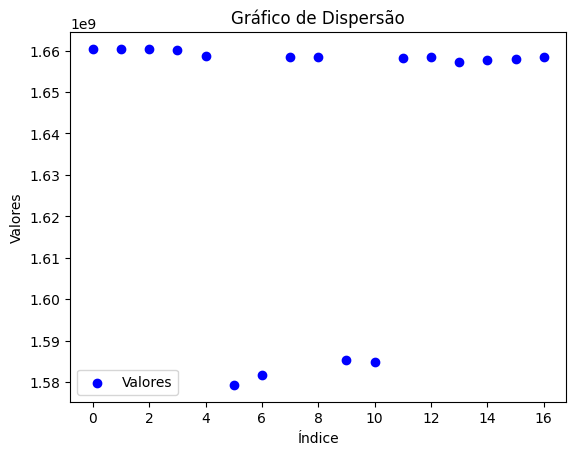

In [106]:
plt.scatter(range(len(timing)), timing, color='blue', label='Valores')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Gráfico de Dispersão')
plt.legend()
plt.show()

#### OBS: Fator nostalgia evidente, ou um split temporal mal feito???

In [107]:
item_data.head()

,page,Unnamed: 0,url,issued,modified,title,body,caption,categorie,saida,label_ft,finetune
0,13db0ab1-eea2-4603-84c4-f40a876c7400,0,http://g1.globo.com/am/amazonas/noticia/2022/0...,2022-06-18 20:37:45+00:00,2023-04-15 00:02:08+00:00,Caso Bruno e Dom: 3º suspeito tem prisão tempo...,"Após audiência de custódia, a Justiça do Amazo...",Jeferson da Silva Lima foi escoltado por agent...,am,apo audiencia custodia justica amazonas decret...,politica,"[0.9932261109352112, 0.9012693762779236, -0.96..."
1,92907b73-5cd3-4184-8d8c-e206aed2bf1c,1,http://g1.globo.com/pa/santarem-regiao/noticia...,2019-06-20 17:19:52+00:00,2023-06-16 20:19:15+00:00,Linguajar dos santarenos é diferenciado e chei...,Vista aérea de Santarém\nÁdrio Denner/ AD Prod...,As expressões santarenas não significam apenas...,pa,vista aerea santar adrio denner ad producoe pa...,economia,"[-0.689832329750061, 0.21615354716777802, 0.80..."
2,61e07f64-cddf-46f2-b50c-ea0a39c22050,2,http://g1.globo.com/mundo/noticia/2022/07/08/e...,2022-07-08 08:55:52+00:00,2023-04-15 04:25:39+00:00,Ex-premiê Shinzo Abe morre após ser baleado no...,Novo vídeo mostra que assassino de Shinzo Abe ...,Ex-primeiro-ministro foi atingido por tiros de...,mundo,video mostrar assassino shinzo abe atirar cost...,mundo,"[-0.9931131601333618, -0.6926692724227905, 0.2..."
3,30e2e6c5-554a-48ed-a35f-6c6691c8ac9b,3,http://g1.globo.com/politica/noticia/2021/09/0...,2021-09-09 19:06:46+00:00,2023-06-07 17:44:54+00:00,"Relator no STF, Fachin vota contra marco tempo...","Relator no STF, Fachin vota contra marco tempo...",Ministro defendeu que posse indígena é diferen...,politica,relator stf fachin vota marco temporal demarca...,politica,"[0.9959969520568848, 0.9293882846832275, -0.97..."
4,9dff71eb-b681-40c7-ac8d-68017ac36675,4,http://g1.globo.com/politica/noticia/2021/09/1...,2021-09-15 19:16:13+00:00,2023-06-07 17:43:39+00:00,"\nApós 2 votos, pedido de vista suspende julga...",Após um pedido de vista (mais tempo para análi...,"Pelo marco temporal, índios só podem reivindic...",politica,apo pedido vista analise processo ministro ale...,politica,"[0.995829164981842, 0.9453511238098145, -0.949..."


In [108]:
user_iter.head()

,userId,history,timestampHistory,timeOnPageHistory,scrollPercentageHistory,pageVisitsCountHistory,famous
0,0,"[193275, 158881, 203270]","1657146417045, 1657146605778, 1657146698738","[20380.0, 21184.0, 35438.0]","[50.3, 18.18, 16.46]","[2.0, 1.0, 1.0]","[334, 134, 242]"
1,1,"[236644, 186368, 154787, 159227, 103615, 23330...","1656684240278, 1656761266729, 1656761528085, 1...","[6049.0, 210489.0, 8672.0, 10000.0, 30000.0, 1...","[25.35, 45.66, 35.3, 28.05, 36.53, 47.57, 55.3...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[25, 2976, 287, 13, 32, 9, 70, 31, 177, 70, 56..."
2,2,"[217268, 105647, 37758, 60121, 96848, 4702, 11...","1656678946256, 1656701076495, 1656701882565, 1...","[311274.0, 140000.0, 32515.0, 157018.0, 118689...","[67.58, 47.22, 41.52, 63.09, 51.38, 65.11, 71....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","[2692, 13715, 1931, 19519, 951, 76, 487, 1125,..."
3,3,"[116062, 217268, 63616, 45463, 158309, 234064,...","1658333312180, 1658404553818, 1658408449062, 1...","[182696.0, 91925.0, 30000.0, 273655.0, 126409....","[58.26, 72.66, 22.57, 59.89, 40.36, 36.35, 14....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[9744, 2692, 1125, 963, 561, 4370, 120, 2927, ..."
4,4,"[12658, 88597, 148651, 165528]","1658766608801, 1658766608801, 1660084035094, 1...","[801396.0, 801396.0, 10000.0, 10000.0]","[78.74, 78.74, 16.71, 9.34]","[7.0, 7.0, 1.0, 1.0]","[76, 1068, 3666, 3666]"


In [109]:
history_count = [len(x) for x in user_iter['history'].values]

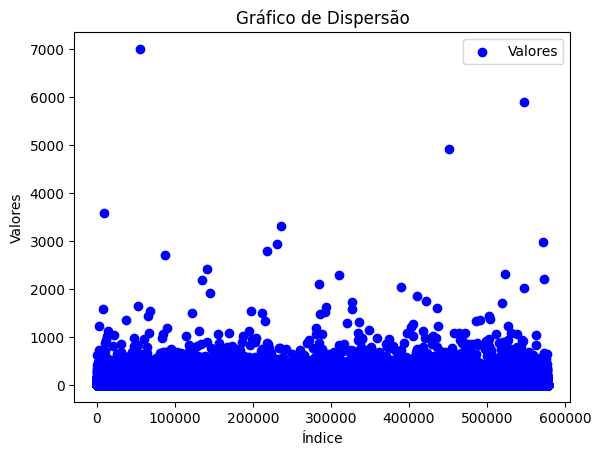

In [110]:
import matplotlib.pyplot as plt

plt.scatter(range(len(history_count)), history_count, color='blue', label='Valores')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Gráfico de Dispersão')
plt.legend()
plt.show()

In [111]:
item_per_feedback = []

## Teste: Collaborative Filtering associado

In [112]:
u_vec = {user:list(set(itens)) for user, itens in user_cat_train.items()}

In [113]:
u_vec = {user: vec for user, vec in u_vec.items() if user in user_predict_itens.keys()}

In [114]:
u_categories = list(u_vec.values())
u_categories = set([el for sub in u_categories for el in sub])

categories2idx = {cat:i for i, cat in enumerate(u_categories)}
idx2categories = {i:cat for i, cat in enumerate(u_categories)}

In [115]:
for user, cats in u_vec.items():
    user_vector = []
    for cat in categories2idx.keys():
        if cat in cats:
            user_vector.append(1)
        else:
            user_vector.append(0)
    u_vec[user] = torch.Tensor(user_vector).unsqueeze(1)

In [116]:
user1_features = torch.cat(list(u_vec.values()), dim=1)

In [117]:
part1 = torch.split(user1_features, split_size_or_sections=56092, dim=1)

In [118]:
part1[0].shape

torch.Size([35, 56092])

### Split da matriz de similaridade: Space Lack

In [119]:
users_sim_1 = torch.mm(part1[0].T, part1[0]).cpu()

In [120]:
users_sim_2 = torch.mm(part1[1].T, part1[1])

In [121]:
users_sim_3 = torch.mm(part1[0].T, part1[1])

In [122]:
users_sim_4 = torch.mm(part1[1].T, part1[0])

In [123]:
users_sim_left = torch.cat([users_sim_1, users_sim_4], dim=0)

: 

: 

In [ ]:
users_sim_right = torch.cat([users_sim_2, users_sim_3], dim=0)

In [ ]:
del users_sim_1, users_sim_2, users_sim_3, users_sim_4

In [ ]:
users_sim = torch.cat([users_sim_left, users_sim_right], dim=1)

In [ ]:
users_sim.shape

torch.Size([112184, 112184])

In [ ]:
del users_sim_left, users_sim_right

In [ ]:
most_similarities = users_sim.argmax(dim=1)

In [ ]:
most_similarities = most_similarities.tolist()

## Teste: Recomendação utilizando Collaborative Filtering associado ao conjunto de recomendação; Fator nostalgia adicionado com peso 10.

In [ ]:
user_most_similar = {}
user_ids = list(user_predict_itens.keys())

for i, u_sim in enumerate(most_similarities):
    user = user_ids[i]
    user_most_similar[user] = user_ids[u_sim]


In [ ]:
recommendations = {}

for user, itens in user_predict_itens.items():
    most_sim = user_most_similar[user]
    itens_sim = user_predict_itens[most_sim]
    hist_itens = user_historical_itens[user][:10]
    # itens = itens + itens_sim
    itens = itens + hist_itens + itens_sim
    if len(itens) < 15:
        itens += toprecents[: (15 - len(itens))]
    recommendations[user] = itens[:15]

In [ ]:
out = {
    "userId": [],
    "acessos_futuros": []
}

users = []
access = []

for user, itens in recommendations.items():
    for item in itens:
        users.append(index2user[user])

        access.append(index2item[item])


out["userId"] = users
out["acessos_futuros"] = access

In [ ]:
df = pd.DataFrame(out)
df.to_csv("Results_2_Review.csv", index=False)